In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/My Drive/data/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    
    
    # resize
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # copy
    gray = tf.identity(image)
    color= tf.identity(image)
    
    # convert to gray
    gray = tf.image.rgb_to_grayscale(gray)
    
    gray  = tf.cast(gray, tf.float32)
    color = tf.cast(color, tf.float32) 

    return gray, color

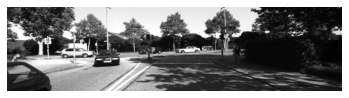

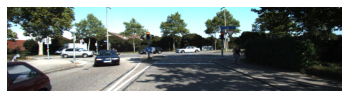

In [ ]:
gray, color = load(PATH+'unet/kitti_train/000008_10.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(gray[:,:,0]/255.0, cmap='gray')
plt.figure()
plt.axis('off')
plt.imshow(color/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_img, target_img):
    input_img  = (input_img / 127.5) - 1
    target_img = (target_img / 127.5) - 1

    return input_img, target_img

def random_jitter(input_img, target_img):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_img  = tf.image.flip_left_right(input_img)
        target_img = tf.image.flip_left_right(target_img)

    return input_img, target_img

def load_image_train(image_file):
    input_img, target_img = load(image_file)
    input_img, target_img = random_jitter(input_img, target_img)
    input_img, target_img = normalize(input_img, target_img)

    return input_img, target_img

def load_image_test(image_file):
    input_img, target_img = load(image_file)
    input_img, target_img = normalize(input_img, target_img)

    return input_img, target_img

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_train/*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_test/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
initializer = tf.keras.initializers.HeNormal()

def extract_first_features(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same', 
                                    kernel_initializer=initializer, use_bias=False))    
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

def downsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                                    kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

def upsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def UNet_process(x): # (1, 256, 1024, 1)
  # encoding
  down_stack = [
    downsample(64, 4),  # (bs, 128, 512, 64)
    downsample(256, 4), # (bs, 64, 256, 256)
    downsample(512, 4), # (bs, 32, 128, 512)
    downsample(512, 4), # (bs, 16, 64, 512)
    downsample(512, 4), # (bs, 8, 32, 512)
  ]

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])


  # decoding
  up_stack = [
    upsample(512, 4), # (bs, 16, 64, 512)
    upsample(512, 4), # (bs, 32, 128, 512)
    upsample(256, 4), # (bs, 64, 256, 256)
    upsample(64, 4),  # (bs, 128, 512, 64)
  ]

  concat = tf.keras.layers.Concatenate()
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  
  # last layer
  OUTPUT_CHANNELS = 3  
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,
                                         padding='same', activation='tanh') # (bs, 256, 1024, 3)
  x = last(x)
    
  return x
    
def Generator(): 
    # multiple inputs
    inputs = tf.keras.layers.Input(shape=[256, 1024, 1])    
    x = inputs

    # extract_first_features
    fextract = extract_first_features(64, 3)
    x = fextract(x) # (1,256,1024,64)
       
    # UNet_process
    fake_color = UNet_process(x)

    return tf.keras.Model(inputs=[inputs], outputs=[fake_color])

In [ ]:
generator = Generator()
generator.summary()

#generator = tf.keras.models.load_model('/content/gdrive/My Drive/Model/1.L1+GAN_23.93321418762207.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 256, 1024, 64 832         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 128, 512, 64) 65792       sequential_10[0][0]              
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 64, 256, 256) 263168      sequential_11[0][0]              
____________________________________________________________________________________________

In [ ]:
def compute_loss(img1, img2):
  return tf.reduce_mean(tf.abs(img1-img2))

img1 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
img2 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
l1_loss = compute_loss(img1, img2)
print(l1_loss.numpy())

1.1272949


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

def evaluate(model, epoch):  
    psnr_mean = 0.0
    count = 0
    for gray, real in test_dataset:
        fake = model([gray], training=True)
         
        psnr = tf.image.psnr(fake*0.5 + 0.5, real*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        
        psnr_mean += __psnr_mean
        count =count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    
def generate_images(model, gray, real):
    fake = model([gray], training=True)
    plt.figure(figsize=(15,20))
    
    display_list = [gray[0,:,:,0], real[0], fake[0]]
    title = ['Input Left', 'Real Left', 'Predicted Left']  

    i = 0
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')

    for i in range(1,3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()        

In [ ]:
@tf.function
def train_step(gray, color):
    with tf.GradientTape() as gen_tape:
        # output
        fake_color = generator([gray], training=True)
        loss = compute_loss(fake_color, color)

    generator_gradients = gen_tape.gradient(loss, generator.trainable_variables)    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return loss    
    
def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        start = time.time()        
       
        # Train
        for gray, color in train_ds:
           loss = train_step(gray, color)
        
        pnsr = evaluate(generator, epoch)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            print(best_pnsr)
            #generator.save('/content/gdrive/My Drive/data/unet/21.2_{}.h5'.format(epoch+1))
             
            for gray, color in test_ds.take(1):
                generate_images(generator, gray, color)


In [ ]:
EPOCHS = 60
fit(train_dataset, EPOCHS, test_dataset)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/My Drive/data/unet/21.2_10.h5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 1024, 64 832         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 512, 64) 65792       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 256, 256) 263168      sequential_1[0][0]               
______________________________________________________________________________________________

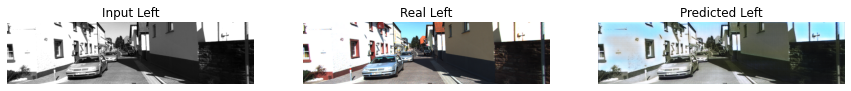

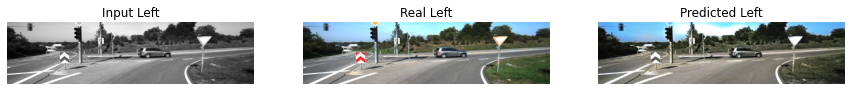

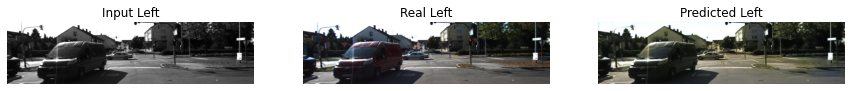

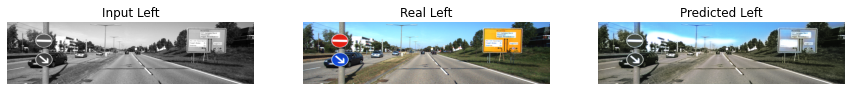

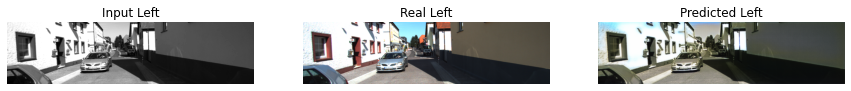

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(new_model, inp, tar)